In [1]:
import time
import json
import multiprocessing as mp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import elasticsearch
from elasticsearch import helpers

import secrets

In [2]:
class AverageOwd():
    def __init__(self,src_host, dest_host,average_delay_mean):
        self.src_host = src_host
        self.dest_host = dest_host
        self.average_delay_mean = average_delay_mean
        
    def __str__(self):
        return "{} -> {} (average delay mean: {})".format(self.src_host, self.dest_host, self.average_delay_mean)
    

In [3]:
def connectDB(user,password):
    '''connect to ElasticSearch db'''
    try:
        es = elasticsearch.Elasticsearch(['atlas-kibana.mwt2.org:9200'], http_auth=(
            user, password), timeout=60, scheme= 'ssl')
        print("Connected", es.info())
        return es

    except Exception as ex:
        print("Error:", ex)

es = connectDB(secrets.user, secrets.password)

Connected {'cluster_name': 'atlas', 'name': 'uct2-c409', 'tagline': 'You Know, for Search', 'version': {'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1', 'build_hash': '1c1faf1', 'lucene_version': '8.1.0', 'build_date': '2019-09-06T14:40:30.409026Z', 'build_flavor': 'default', 'build_snapshot': False, 'build_type': 'rpm', 'number': '7.3.2'}, 'cluster_uuid': 'HvlJZuzTRReL9Gq1KVSIHQ'}


In [4]:
def cacheDict(filePath, dictionary):
    '''utility function to cache data as dictionary '''
    from pathlib import Path
    path = Path(filePath)
    path.write_text( json.dumps(dictionary) )

In [5]:
def getAvgDelayMean(from_date,to_date):
    '''Get average delay_mean for each unique source-destination pair within the given time range.'''
    get_avg_delay_mean_query = {
                "size":0,
                "query":{
                    "bool":{
                        "must":[
                            {
                                "range":{
                                    "timestamp":{
                                        "gte":from_date,
                                        "lte":to_date,
                                        "format":"yyyy/MM/dd||epoch_millis"
                                    }
                                }
                            },
                            {
                                "term":{
                                    "dest_production":{
                                        "value":"true"
                                    }
                                }
                            },
                            {
                                "term":{
                                    "src_production":{
                                        "value":"true"
                                    }
                                }
                            }
                        ]
                    }
                },
                "aggs":{
                    "sources":{
                        "terms":{
                            "field":"src_host",
                            "size":9999
                        },
                        "aggs":{
                            "destinations":{
                                "terms":{
                                    "field":"dest_host",
                                    "size":9999
                                },
                                "aggs":{
                                    "average_delay_mean":{
                                        "avg":{
                                            "field":"delay_mean"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
    
    results = es.search('ps_owd', body=get_avg_delay_mean_query)
    return results

In [7]:
results = getAvgDelayMean("2019/10/05","2019/10/15")

In [18]:
timestr = time.strftime("%Y%m%d-%H%M%S")
cacheDict('./cached_owd_data'+ timestr +'.json', results)
print('Successfully cached owd data.')

Successfully cached owd data.


In [8]:
def createInstancesFromData(results):
    '''
    Create average_owd class instance from results returned from ElasticSearch.
    '''
    instances = []
    for info_dct in results["aggregations"]["sources"]["buckets"]:
        src_host = info_dct["key"]
        destinations = info_dct["destinations"]["buckets"]
        for dest in destinations:
            dest_host = dest["key"]
            avg_delay_mean = dest["average_delay_mean"]["value"]
            instance = AverageOwd(
                src_host = src_host,
                dest_host = dest_host,
                average_delay_mean = avg_delay_mean 
            )
            instances.append(instance)
    return instances

avg_owd_instances = createInstancesFromData(results)
print(avg_owd_instances[0])

ccperfsonar2.in2p3.fr -> lhcperfmon.bnl.gov (average delay mean: 21.4387247369455)


In [9]:
# format class data into a nd-array for seaborn visualization
sources = [instance.src_host for instance in avg_owd_instances]
destinations = [instance.dest_host for instance in avg_owd_instances]
avg_delays = [instance.average_delay_mean for instance in avg_owd_instances]
df = pd.DataFrame({'source_host':sources, 'dest_host': destinations, 'average_owd':avg_delays})
df.head(20)

,average_owd,dest_host,source_host
0,21.438725,lhcperfmon.bnl.gov,ccperfsonar2.in2p3.fr
1,70.391343,ps-latency.hepnetcanada.ca,ccperfsonar2.in2p3.fr
2,-4.918307,lapp-ps02.in2p3.fr,ccperfsonar2.in2p3.fr
3,-0.757646,perfsonar-ow.cnaf.infn.it,ccperfsonar2.in2p3.fr
4,3.164470,psonar1.lal.in2p3.fr,ccperfsonar2.in2p3.fr
5,-0.489464,perfsonar01.datagrid.cea.fr,ccperfsonar2.in2p3.fr
6,-2.167557,lpnhe-psl.in2p3.fr,ccperfsonar2.in2p3.fr
7,2.933159,llrpsonar1.in2p3.fr,ccperfsonar2.in2p3.fr
8,8.920043,perfsonar2.na.infn.it,ccperfsonar2.in2p3.fr
9,5.811328,marperf02.in2p3.fr,ccperfsonar2.in2p3.fr


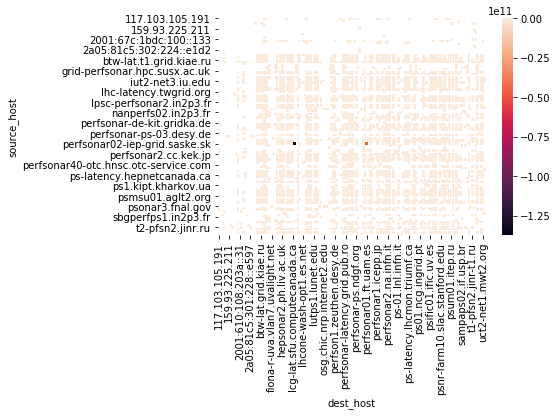

In [10]:
pivot_df = df.pivot('source_host','dest_host','average_owd')
min_avg_delay, max_avg_delay = min(df['average_owd']), max(df['average_owd'])
ax = sns.heatmap(pivot_df,vmin=min_avg_delay, vmax=max_avg_delay)

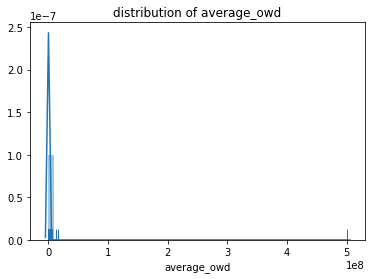

In [12]:
average_owd = df['average_owd'].to_list()
average_owd_above_zero = [val for val in average_owd if val >= 0]
ax = sns.distplot(average_owd_above_zero, rug=True)
ax.set(xlabel='average_owd',title='distribution of average_owd')
plt.show()